In [12]:
import requests
from PIL import Image
import io
# import tensorflow as tf
import torch
import datetime
from pathlib import Path
from datasets import DatasetDict
from datasets import Dataset
from datasets import load_from_disk
import time
from tqdm import tqdm

In [13]:
from datasets import load_dataset

# this line is just for quick testin
dataset = load_dataset("stochastic/random_streetview_images_pano_v0.0.2", split="train[:200]")
# dataset = load_dataset("stochastic/random_streetview_images_pano_v0.0.2", split="train")

In [14]:
# filter all the countries with not many images out of the dataset
passes = ['HK', 'HU', 'AU', 'SK', 'FR', 'FI', 'ZA', 'LT', 'PE', 'US']  # 10 most common

# Function to apply the filter
def filter_countries(example):
    return example['country_iso_alpha2'] in passes

# Apply the filter to the dataset
dataset = dataset.filter(filter_countries)

In [15]:
# test out the filtering
dataset

Dataset({
    features: ['image', 'country_iso_alpha2', 'latitude', 'longitude', 'address'],
    num_rows: 106
})

In [16]:
# preprocessing - this took 6min 48 seconds on my computer... jk 12 min second time
from torchvision.transforms import v2
import torchvision.transforms as transforms

# data preprocessing
image_transforms = v2.Compose([
    v2.CenterCrop((561, 1010)),  # crops the middle image from the panorama
    v2.Resize((224, 224)),  # resizing the image to 224x224 for easier processing
    transforms.ToTensor()  # converting the image to a tensor
])

def transform(batch):
    # Transform each image in the batch and ensure it has 3 channels
    batch["image"] = [image_transforms(image.convert("RGB")) for image in batch["image"]]
    del batch["latitude"]
    del batch["longitude"]
    del batch["address"]
    return batch

# Apply the transformations to the dataset
dataset = dataset.map(transform, batched=True, batch_size=8)


Map: 100%|██████████| 106/106 [00:08<00:00, 13.24 examples/s]


In [17]:
# check what the name of the country thing is
# print(dataset[0])

In [18]:
# Make split and save
train_testvalid = dataset.train_test_split(test_size=0.4)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

datasets = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})
datasets.save_to_disk("./data")

Saving the dataset (1/1 shards): 100%|██████████| 21/21 [00:00<00:00, 387.17 examples/s]


In [19]:
# country_codes = ["ZA","KR","AR","BW","GR","SK","HK","NL","PE","AU","KH","LT","NZ","RO","MY","SG","AE","FR","ES","IT","IE","LV","IL","JP","CH","AD","CA","RU","NO","SE","PL","TW","CO","BD","HU","CL","IS","BG","GB","US","SI","BT","FI","BE","EE","SZ","UA","CZ","BR","DK","ID","MX","DE","HR","PT","TH"]
country_codes = ['HK', 'HU', 'AU', 'SK', 'FR', 'FI', 'ZA', 'LT', 'PE', 'US']
country_dict = {}
# TODO: these might need to be tensor arrays but thats easy enough to change if needed
for i in range(len(country_codes)):
    country_dict[country_codes[i]] = [0.]*len(country_codes)
    country_dict[country_codes[i]][i] = 1.
# print(country_dict)
country_dict_not_one_hot = {}
for i in range(len(country_codes)):
    country_dict_not_one_hot[country_codes[i]] = i

In [20]:
# referenced: https://blog.paperspace.com/convolutional-autoencoder/
# autoencoder classes (CREDIT: LARGELY TAKEN FROM 6_AUTOENCODER NOTEBOOK, but encoder and decoder architectures modified to be convolutional)
# should only have Encoder that has a latent dimension of 50 - corresponding to country weights
import torch.nn as nn
import torch.nn.functional as F

class MLPEncoder(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 latent_size: int,
                 hidden_size: int,
                 input_size: int,
                 activation: torch.nn.Module):

        super().__init__()

        self.latent_size = latent_size
        assert number_of_hidden_layers >= 0, "Decoder number_of_hidden_layers must be at least 0"

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)

        self.feature_map_size = 128 * 14 * 14
        
        # Fully connected layer to produce the latent representation of size 55
        self.fc = nn.Linear(self.feature_map_size, latent_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.feature_map_size)  # Flatten the output
        x = self.fc(x)
        return x


In [21]:
# define our training parameters and model
hidden_layers = 4
hidden_size = 30
latent_size = 10
input_size = 224
lr = 0.005
lamb = 1

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPEncoder( number_of_hidden_layers=hidden_layers,
                 latent_size=latent_size,
                 hidden_size=hidden_size,
                 input_size=input_size,
                 activation=torch.nn.ReLU()).to(device)

# use an optimizer to handle parameter updates
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
!rm -rf ./logs/

# timestamp the logs for each run so we can sort through them
run_time = datetime.datetime.now().strftime("%I%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
from torch.utils.tensorboard import SummaryWriter
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

2024-03-14 01:32:49.007118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# model(data['train'][0]['image'].to(device)).shape

In [24]:
# load data from disk
data = load_from_disk("./data")
data = data.with_format("torch")

In [25]:
# test the datatype of the dataset - the datasets['train']['image'] should be a tensor
# type(datasets['train'][0]['image'])
# datasets['train'][0]['image']

torch.tensor(data['train'][0]['image']).shape
# print(len(datasets['train'][0]['image'][0]))
# print(len(datasets['train'][0]['image'][0][0]))


/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_15115/3299156962.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data['train'][0]['image']).shape


torch.Size([3, 224, 224])

In [26]:
# (***credit***: mostly taken from provided notebook )
# training
torch.autograd.set_detect_anomaly(False)

epochs = 100
batch_size = 1000
start_time = time.time()
loss_history = []
valid_history = []
acc_history = []
valid_acc_history = []
report_every = 1
# Loss = torch.nn.BCELoss()
Loss = torch.nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(data['test'], batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(data['valid'], batch_size=batch_size, shuffle=True)


for epoch in range(epochs):
    model.train()
    # weight batch losses/scores proportional to batch size
    iter_count = 0
    valid_iter_count = 0
    loss_epoch = 0.
    class_accuracy_epoch = 0.
    valid_loss_epoch = 0.
    valid_accuracy_epoch = 0.
    ###
    ### IMAGE_DATA_TRAIN is training data, shape is 610 x 3 x 64 x 64
    ### 
    
   # print(batched_image_data_train[0][0].shape)
    #batched_image_data_train = [batched_image_data_train[0][0].unsqueeze(0)]
    for idx, batch in enumerate(train_loader):
        
        x = batch['image']
        x = torch.tensor(x)
        # print(x)
        # flatten input images and move to device\
        # *****
        # x = x / 255
        # plot x_real later to see if this is correct
        x = x.to(device)
        model.zero_grad()
        opt.zero_grad()

        # train on a batch of inputs
        pred_labels = model(x)
        # print(pred_labels)

        # get the true label
        # label = torch.tensor(country_dict[img['country_iso_alpha2']], dtype=torch.float).to(device).unsqueeze(0)
        # print(batch['country_iso_alpha2'])
        labels = torch.tensor([country_dict_not_one_hot[country] for country in batch['country_iso_alpha2']]).to(device)
        # print(labels)
        # print(len(country_dict))
        # pred labels is 4x56
        # print(len(pred_labels))
        # print(len(pred_labels[0]))
        # label is 1x56

        loss = Loss(pred_labels, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        # log loss
        loss_epoch += loss.detach().item()    

        # classification accuracy
        # add 1 to class_accuracy_epoch if the classification is correct, else 0
        # find index of max probability from pred_labels
        for i in range(len(pred_labels)):
            c = torch.argmax(pred_labels[i])
            # find index of 1 from label
            true_class = torch.argmax(labels[i])
            acc = (true_class == c)
            class_accuracy_epoch += acc
            iter_count += 1
        c = torch.argmax(pred_labels)

        # print(f"true: {true_class}")
        # print(f"pred: {classification.mean()}")
        # print(f"acc: {acc}")

        # plot loss
        class_accuracy_epoch /= iter_count #accuracy as a percent
    # print(iter_count)
        # logger.add_scalar("mse_loss", loss_epoch, epoch)
        loss_history.append(loss_epoch)
        acc_history.append(class_accuracy_epoch) 
    
                
                # logger.add_scalar("mse_loss_valid", valid_loss_epoch, epoch)
        # # plot example generated images
        # with torch.no_grad():
        #     reconstructed_batch = model(example_batch.reshape(batch_size, -1)).reshape(batch_size, 1, image_size, image_size)
        #     logger.add_image("reconstructed_images", make_grid(reconstructed_batch, math.floor(math.sqrt(batch_size)), title="Reconstructed Images"), epoch)
            # calculate validation loss

        with torch.no_grad():
            model.eval()
            for idx, valid_data in enumerate(valid_loader):
                x_valid = torch.tensor(valid_data['image']) #.float()
                # x_valid = x_valid / 255
                x_valid = x_valid.to(device)
                # print(x_valid)
                pred_labels = model(x_valid)

                labels_valid = torch.tensor([country_dict_not_one_hot[country] for country in valid_data['country_iso_alpha2']]).to(device)
                # print(label_valid)
                # print(pred_labels)
                valid_loss = Loss(pred_labels, labels_valid)
                valid_loss_epoch += valid_loss.detach().item()

                
                # classification accuracy
                # add 1 to class_accuracy_epoch if the classification is correct, else 0
                for i in range(len(pred_labels)):
                    c = torch.argmax(pred_labels[i])
                    # find index of 1 from label
                    true_class = torch.argmax(labels_valid[i])
                    acc = (true_class == c)
                    valid_accuracy_epoch += acc
                    valid_iter_count += 1
                # print(f"true: {true_class}")
                # print(f"pred: {classification.mean()}")
                # print(f"acc: {valid_acc}")
            valid_loss_epoch 
            valid_history.append(valid_loss_epoch)
            valid_accuracy_epoch /= valid_iter_count
            valid_acc_history.append(valid_accuracy_epoch)

    if (epoch + 1) % report_every == 0:
        mins = (time.time() - start_time) / 60
        print(f"Epoch: {epoch + 1:5d}\tMSE Loss: {loss_epoch :6.4f}\t in {mins:5.1f}min")
        print()

/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_15115/1485996735.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/vc/7kh7f0_n749bhl6c8b17t3q40000gn/T/ipykernel_15115/1485996735.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid = torch.tensor(valid_data['image']) #.float()


Epoch:     1	MSE Loss: 2.2985	 in   0.1min

Epoch:     2	MSE Loss: 6.7871	 in   0.1min

Epoch:     3	MSE Loss: 2.6332	 in   0.1min

Epoch:     4	MSE Loss: 2.1986	 in   0.2min

Epoch:     5	MSE Loss: 2.2165	 in   0.2min

Epoch:     6	MSE Loss: 2.0785	 in   0.2min

Epoch:     7	MSE Loss: 1.9593	 in   0.2min

Epoch:     8	MSE Loss: 1.7443	 in   0.3min

Epoch:     9	MSE Loss: 1.4042	 in   0.3min

Epoch:    10	MSE Loss: 0.9898	 in   0.3min

Epoch:    11	MSE Loss: 0.6936	 in   0.4min

Epoch:    12	MSE Loss: 0.3444	 in   0.4min

Epoch:    13	MSE Loss: 0.5928	 in   0.4min

Epoch:    14	MSE Loss: 0.6938	 in   0.5min

Epoch:    15	MSE Loss: 0.8272	 in   0.5min

Epoch:    16	MSE Loss: 0.2571	 in   0.5min

Epoch:    17	MSE Loss: 0.0137	 in   0.6min

Epoch:    18	MSE Loss: 0.0392	 in   0.6min

Epoch:    19	MSE Loss: 0.1046	 in   0.6min

Epoch:    20	MSE Loss: 0.0008	 in   0.6min

Epoch:    21	MSE Loss: 0.1892	 in   0.7min

Epoch:    22	MSE Loss: 0.1643	 in   0.7min

Epoch:    23	MSE Loss: 0.0035	 i

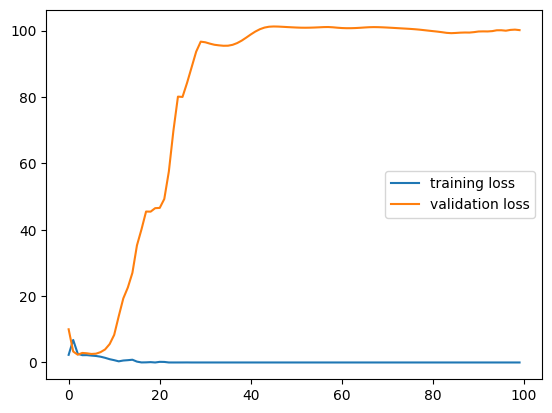

In [27]:
# plot loss history
import matplotlib.pyplot as plt
plt.plot(loss_history, label="training loss")
plt.plot(valid_history, label="validation loss")
plt.legend()
plt.show()

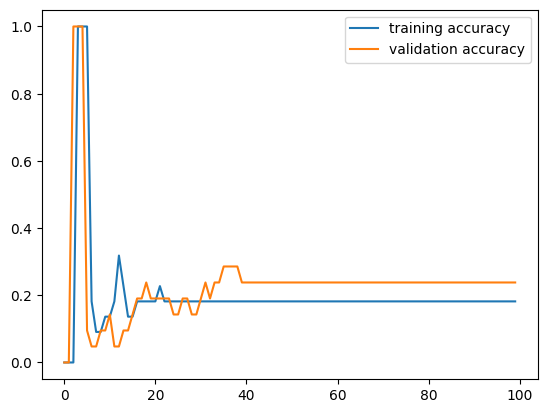

In [28]:
# plot accuracy history
plt.plot(acc_history, label="training accuracy")
plt.plot(valid_acc_history, label="validation accuracy")
plt.legend()
plt.show()


In [ ]:
def predict(i):
    prediction = model(data['train'][i]['image'].to(device))
    country = torch.argmax(prediction)
    return country_codes[country]

In [ ]:
from collections import Counter
Counter([predict(i) for i in range(100)])

Counter({'SK': 31,
         'AU': 25,
         'HU': 11,
         'FI': 8,
         'US': 7,
         'HK': 6,
         'PE': 3,
         'ZA': 3,
         'CA': 2,
         'SG': 1,
         'BG': 1,
         'LT': 1,
         'FR': 1})

In [ ]:
# find most common countries in dataset
from collections import Counter
country_counts = Counter(data['test']['country_iso_alpha2'])
print(country_counts.most_common(10))


[('HK', 5), ('HU', 5), ('AU', 4), ('SK', 4), ('FR', 3), ('FI', 2), ('ZA', 2), ('LT', 2), ('PE', 2), ('US', 2)]
